In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torchsummary import summary as summary_
import matplotlib.pyplot as plt
import numpy as np

c:\Users\user\.conda\envs\test\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\user\.conda\envs\test\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\user\.conda\envs\test\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [3]:
noise_factor = 0.2
EPOCH = 30
BATCH_SIZE = 64
NUM_WORKERS = 2
learning_rate = 0.005

In [4]:
def add_noise(img):
    noise = torch.randn(img.size()) * noise_factor
    noisy_img = img + noise
    return noisy_img


In [5]:
# Fashion MNIST 데이터셋 불러오기
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = NUM_WORKERS
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    num_workers = NUM_WORKERS
)

In [6]:
# 오토인코더 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()


        self.encoder = nn.Sequential( # nn.Sequential을 사용해 encoder와 decoder 두 모듈로 묶어줍니다.
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(1, -1),
            nn.Linear(32*7*7, 64),
            nn.ReLU(),
            nn.Linear(64,3)

        )
        self.decoder = nn.Sequential(
            nn.Linear(3,64),
            nn.ReLU(),
            nn.Linear(64,32*7*7),
            nn.ReLU(),
            nn.Unflatten(1,(32,7,7)),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2),
            nn.Sigmoid()       # 픽셀당 0과 1 사이로 값을 출력하는 sigmoid()함수를 추가합니다.
        )

    def forward(self, x):
        encoded = self.encoder(x) # encoder는 encoded라는 latent vector를 만들고
        decoded = self.decoder(encoded) # decoder를 통해 decoded라는 복원이미지를 만듭니다.
        return encoded, decoded

In [7]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate) 
criterion = nn.MSELoss()

In [8]:
summary_(autoencoder.encoder, (1,28,28), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 16, 28, 28]             160
              ReLU-2           [64, 16, 28, 28]               0
         MaxPool2d-3           [64, 16, 14, 14]               0
            Conv2d-4           [64, 32, 14, 14]           4,640
              ReLU-5           [64, 32, 14, 14]               0
         MaxPool2d-6             [64, 32, 7, 7]               0
           Flatten-7                 [64, 1568]               0
            Linear-8                   [64, 64]         100,416
              ReLU-9                   [64, 64]               0
           Linear-10                    [64, 3]             195
Total params: 105,411
Trainable params: 105,411
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 21.50
Params size (MB): 0.40
Estimated 

In [9]:
summary_(autoencoder.decoder, (3,), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [64, 64]             256
              ReLU-2                   [64, 64]               0
            Linear-3                 [64, 1568]         101,920
              ReLU-4                 [64, 1568]               0
         Unflatten-5             [64, 32, 7, 7]               0
   ConvTranspose2d-6           [64, 16, 14, 14]           2,064
              ReLU-7           [64, 16, 14, 14]               0
   ConvTranspose2d-8            [64, 1, 28, 28]              65
           Sigmoid-9            [64, 1, 28, 28]               0
Total params: 104,305
Trainable params: 104,305
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 6.19
Params size (MB): 0.40
Estimated Total Size (MB): 6.59
-------------------------------------------

In [10]:
# 원본 이미지를 시각화 하기 (첫번째 열)
view_data = testset.data[:10].view(-1, 1, 28, 28)
view_data = view_data.type(torch.FloatTensor)/255.
#픽셀의 색상값이 0~255이므로 모델이 인식하는 0부터 1사이의 값으로 만들기 위해 255로 나눠줍니다.
view_data = add_noise(view_data)
view_data = torch.clamp(view_data, min=0.0, max=1.0)

In [11]:
# 학습하기 위한 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    total_loss=0
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 1, 28, 28).to(DEVICE)
        x_noised = add_noise(x)
        x_noised = torch.clamp(x_noised, min=0.0, max=1.0)
        y = x.view(-1, 1, 28, 28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x_noised)

        loss = criterion(decoded, y)
        total_loss = total_loss + loss
        optimizer.zero_grad() #기울기에 대한 정보를 초기화합니다.
        loss.backward() # 기울기를 구합니다.
        optimizer.step() #최적화를 진행합니다.

    total_loss = total_loss.item()
    print("total train loss:" + str(total_loss))
    
    return total_loss

In [12]:
def test(autoencoder, test_loader):
    autoencoder.eval()
    total_loss=0
    for step, (x, label) in enumerate(test_loader):
        x = x.view(-1, 1, 28, 28).to(DEVICE)
        x_noised = add_noise(x)
        x_noised = torch.clamp(x_noised, min=0.0, max=1.0)
        y = x.view(-1, 1, 28, 28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x_noised)

        loss = criterion(decoded, y) # decoded와 원본이미지(y) 사이의 평균제곱오차를 구합니다
        total_loss = total_loss + loss


    total_loss = total_loss.item()
    print("total test loss:" + str(total_loss))
    
    return total_loss

total train loss:33.1311149597168
total test loss:4.417135715484619
[Epoch 1]


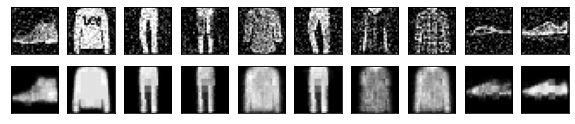

total train loss:25.240676879882812
total test loss:4.131258010864258
[Epoch 2]


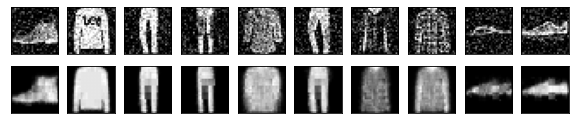

total train loss:24.3848876953125
total test loss:4.011230945587158
[Epoch 3]


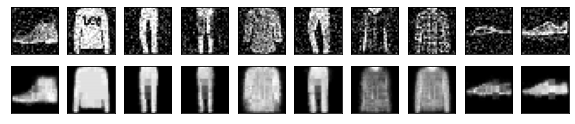

total train loss:23.905794143676758
total test loss:4.1006598472595215
[Epoch 4]


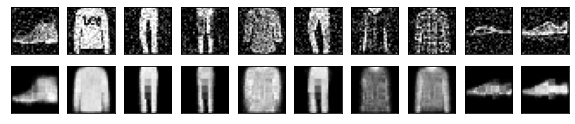

total train loss:23.60825538635254
total test loss:3.925680637359619
[Epoch 5]


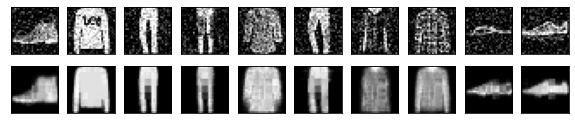

total train loss:23.440690994262695
total test loss:3.913226366043091
[Epoch 6]


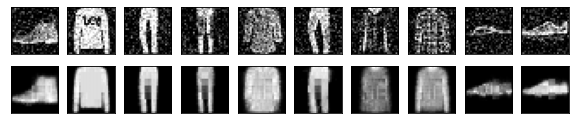

total train loss:23.25259780883789
total test loss:3.888550043106079
[Epoch 7]


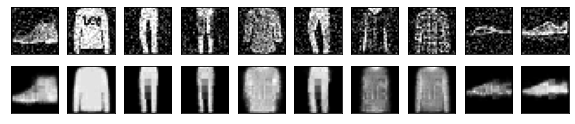

total train loss:23.124860763549805
total test loss:3.918505907058716
[Epoch 8]


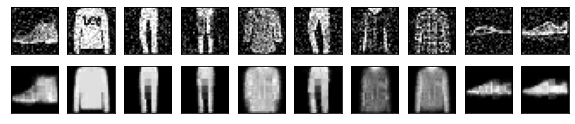

total train loss:23.03980255126953
total test loss:3.8757431507110596
[Epoch 9]


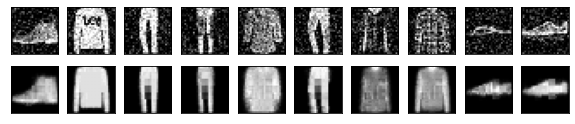

total train loss:22.894285202026367
total test loss:3.8748388290405273
[Epoch 10]


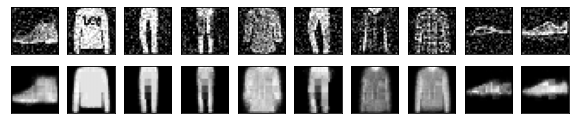

total train loss:22.77274513244629
total test loss:3.858368396759033
[Epoch 11]


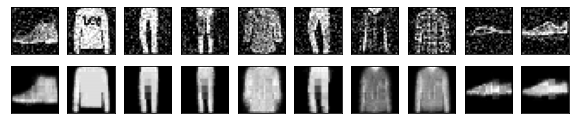

total train loss:22.835174560546875
total test loss:3.8780646324157715
[Epoch 12]


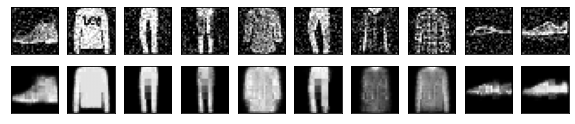

total train loss:22.666954040527344
total test loss:3.7762582302093506
[Epoch 13]


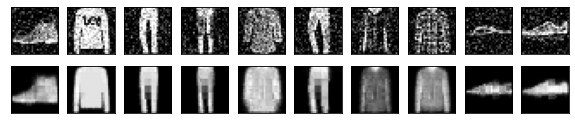

total train loss:22.58490753173828
total test loss:3.7957587242126465
[Epoch 14]


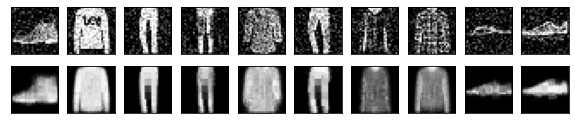

total train loss:22.50764274597168
total test loss:3.844324827194214
[Epoch 15]


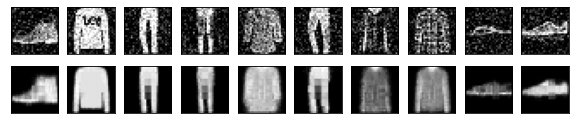

total train loss:22.4804630279541
total test loss:4.038107395172119
[Epoch 16]


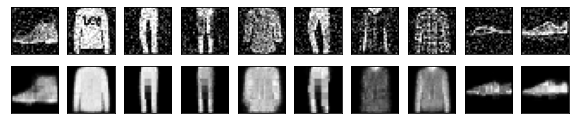

total train loss:22.452634811401367
total test loss:3.7583673000335693
[Epoch 17]


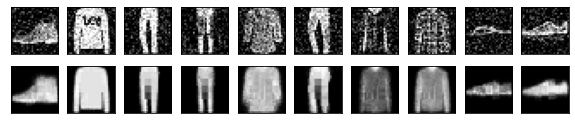

total train loss:22.332990646362305
total test loss:3.7512059211730957
[Epoch 18]


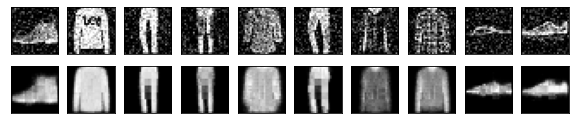

total train loss:22.367366790771484
total test loss:3.72412109375
[Epoch 19]


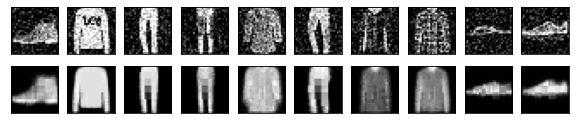

total train loss:22.2430477142334
total test loss:3.7982964515686035
[Epoch 20]


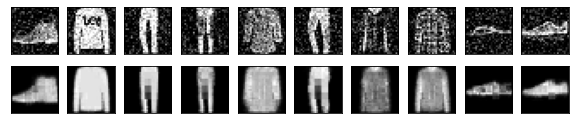

total train loss:22.269357681274414
total test loss:3.7488884925842285
[Epoch 21]


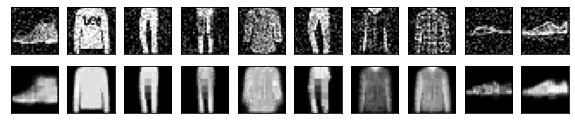

total train loss:22.161237716674805
total test loss:3.7430970668792725
[Epoch 22]


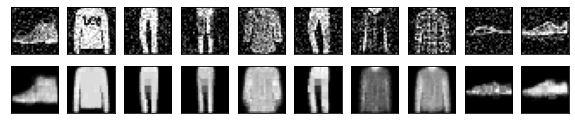

total train loss:22.093219757080078
total test loss:3.7052788734436035
[Epoch 23]


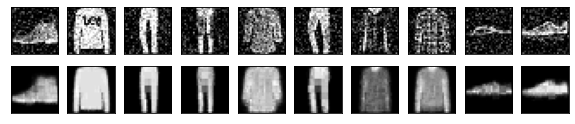

total train loss:22.04761505126953
total test loss:3.718904495239258
[Epoch 24]


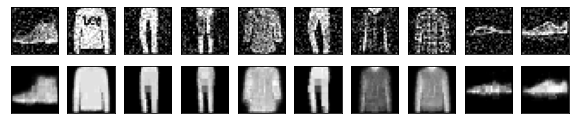

total train loss:21.977352142333984
total test loss:3.715378522872925
[Epoch 25]


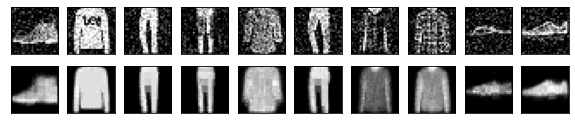

total train loss:22.016910552978516
total test loss:3.7227089405059814
[Epoch 26]


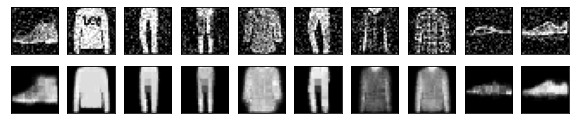

total train loss:22.026687622070312
total test loss:3.7098231315612793
[Epoch 27]


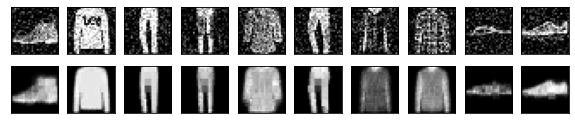

total train loss:21.924163818359375
total test loss:3.6760551929473877
[Epoch 28]


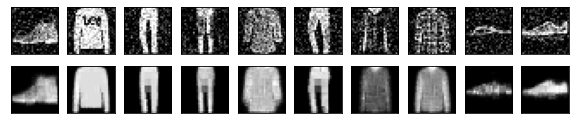

total train loss:21.846698760986328
total test loss:3.7076356410980225
[Epoch 29]


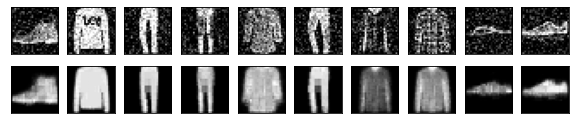

total train loss:21.919370651245117
total test loss:3.68127703666687
[Epoch 30]


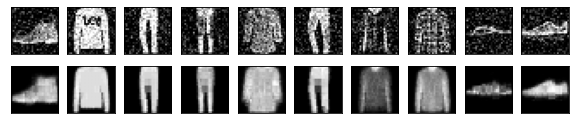

In [13]:
train_losses=[]
test_losses=[]
#학습하기
for epoch in range(1, EPOCH+1):
    loss_epoch = train(autoencoder, train_loader)
    train_losses.append(loss_epoch)

    loss_epoch = test(autoencoder, test_loader)
    test_losses.append(loss_epoch)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(10):
        img = np.reshape(view_data.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(10):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28)) 
        # CUDA를 사용하면 모델 출력값이 GPU에 남아있으므로 .to("cpu") 함수로 일반메모리로 가져와 numpy행렬로 변환합니다.
        # cpu를 사용할때에도 같은 코드를 사용해도 무방합니다.
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

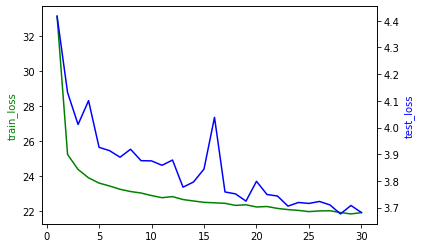

In [14]:
x = range(1,EPOCH+1)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, train_losses, 'g-')
ax2.plot(x, test_losses, 'b-')
ax1.set_ylabel('train_loss', color='g')
ax2.set_ylabel('test_loss', color='b')
plt.show()
